In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random

import MDAnalysis as mda

from mdvcontainment import Containment
import mdvcontainment.composition_logic as cl

import warnings
warnings.filterwarnings("ignore")

In [33]:
vmd = "/Applications/VMD\ 1.9.4a57-arm64-Rev12.app/Contents/MacOS/startup.command.csh"

# Loading and voxelizing the PCD

In [34]:
# Systems
settings = {}
settings['complex3D'] = ('../structures/complex3D.gro',  'name True', 1, '') # Artificial grid
settings['vesicle'] = ('../structures/vesicle.gro',  'name [CD][234][AB]', 0.5, 'de') # CG Martini
settings['transfection'] = ('../structures/transfection.gro',  'name [CD][234][AB]', 0.5, 'de') # CG Martini
settings['syn3a'] = ('md_2000ns.gro',  'all', 0.5, 'de') # CG Martini

# Settings
no_mapping = False
verbose = False
selected_settings = 'transfection'
gro, selection_string, resolution, morph = settings[selected_settings]

In [35]:
u = mda.Universe(gro)
selection = u.select_atoms(selection_string)

# Running an example

In [36]:
# Running the containment calculation
containment = Containment(
    selection, resolution=resolution, morph=morph, 
    max_offset=0.05, no_mapping=no_mapping,
    verbose=verbose)

# Show the containment
print(containment)

Containment Graph with 8 components (component: nm^3: rank):
├── [-6: 79573: 2]
│   └── [2: 7262: 0]
│       ├── [-2: 378: 0]
│       ├── [-5: 749: 0]
│       ├── [-4: 1062: 0]
│       ├── [-3: 348: 0]
│       └── [-1: 356: 0]
└── [1: 3884: 2]



In [37]:
#TODO THIS SHOULD CHECK THE NM NOT THE NVOXELS
valid_containment = containment.node_view(min_size=400)
print(valid_containment)
valid_containment

Containment Graph with 5 components (component: nm^3: rank):
├── [1: 3884: 2]
└── [-6: 79573: 2]
    └── [2: 8345: 0]
        ├── [-5: 749: 0]
        └── [-4: 1062: 0]



<ContainmentView with 198712 atoms in a (92, 92, 89) grid with a resolution of 0.5 nm>

In [38]:
from mdvcontainment.atomgroup_to_voxels import dilate_voxels
from mdvcontainment.voxels_to_gro import voxels_to_gro

In [39]:
def find_midplane(out, inner, max_iterations=20):
    """
    Finds the midplane between two regions by growing them towards each other.
    
    Parameters
    ----------
    out : boolean 3D array
        Outer region mask
    inner : boolean 3D array
        Inner region mask
    max_iterations : int
        Maximum number of iterations to prevent infinite loops
    
    Returns
    -------
    midplane : boolean 3D array
        Mask of the midplane where the two regions meet
    """
    # Work on copies so we don't modify the originals
    out_growing = out.copy()
    inner_growing = inner.copy()
    midplane = np.zeros_like(out, dtype=bool)
    
    for i in range(max_iterations):
        # Dilate both regions
        out_dilated = dilate_voxels(out_growing)
        inner_dilated = dilate_voxels(inner_growing)
        
        # Find where they collide
        collision = out_dilated & inner_dilated
        
        # Add collisions to midplane
        midplane |= collision
        
        # Remove collision voxels from both growing regions
        out_growing = out_dilated & ~collision
        inner_growing = inner_dilated & ~collision
    
    return midplane

In [40]:
outside = valid_containment.voxel_containment.root_nodes[0]
inside = valid_containment.voxel_containment.leaf_nodes[0]

outside_mapping = valid_containment.get_original_nodes(outside)
inside_mapping = valid_containment.get_original_nodes(inside)

In [41]:
inside_voxels_array = np.zeros(valid_containment.voxel_containment.components_grid.shape, dtype=bool)
outside_voxels_array = np.zeros(valid_containment.voxel_containment.components_grid.shape, dtype=bool)
inside_mask = np.isin(valid_containment.voxel_containment.components_grid, inside_mapping)
outside_mask = np.isin(valid_containment.voxel_containment.components_grid, outside_mapping)
inside_voxels_array[inside_mask] = 1
outside_voxels_array[outside_mask] = 1

In [42]:
midplane_array = find_midplane(inside_voxels_array, outside_voxels_array, max_iterations=20)

In [43]:
voxels_to_gro('midplane_voxels.gro', midplane_array, nodes=1)

In [44]:
trimmed_membrane_atomgroup = valid_containment.get_atomgroup_from_voxel_positions(np.array(np.where(midplane_array)).T)
print(trimmed_membrane_atomgroup)

<AtomGroup [<Atom 154568: GL1 of type G of resname DYPC, resid 72449 and segid SYSTEM>, <Atom 154570: C1A of type C of resname DYPC, resid 72449 and segid SYSTEM>, <Atom 130105: C3B of type C of resname DLPC, resid 70002 and segid SYSTEM>, ..., <Atom 147878: GL1 of type G of resname DYPS, resid 71780 and segid SYSTEM>, <Atom 147879: GL2 of type G of resname DYPS, resid 71780 and segid SYSTEM>, <Atom 147876: CNO of type C of resname DYPS, resid 71780 and segid SYSTEM>]>


In [45]:
trimmed_membrane_atomgroup.write('midplane_membrane.gro')

In [46]:
# Write the processed universe to a pdb. The component labeling
# to the betafactors in PDBs occurs in place. Or is done upon instantiation
# of the Containment object.
#containment.set_betafactors()
containment.universe.atoms.write('components.pdb')

In [48]:
#!{vmd} components.pdb # The components are written to the betafactors

In [49]:
# We can filter out noise nodes by using their downstream voxel size as a threshold
# A view can be made on a containment to only include a subset of nodes, merging the nodes 
# that are not included into their ancestors.
containment_size_filtered = containment.node_view(min_size=400)
print(containment_size_filtered)

Containment Graph with 5 components (component: nm^3: rank):
├── [1: 3884: 2]
└── [-6: 79573: 2]
    └── [2: 8345: 0]
        ├── [-5: 749: 0]
        └── [-4: 1062: 0]



## Plot the compositions of all components in the Containment(View)
We want to obtain a nice multigraph where the colors are consistent for the labels.

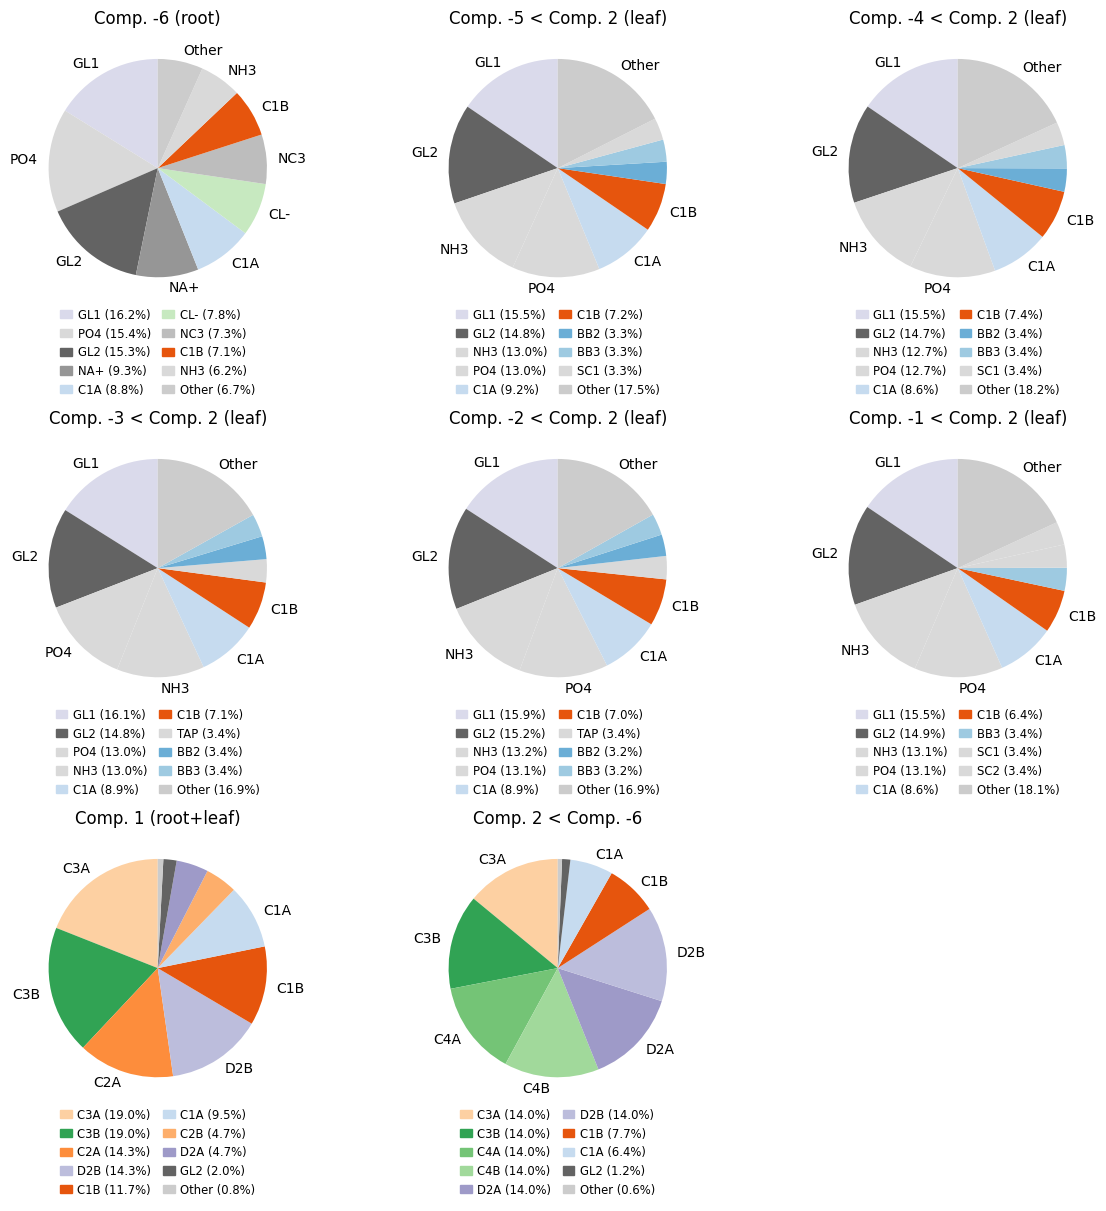

In [50]:
composition, fig, axs = cl.analyze_composition(containment, mode='names')

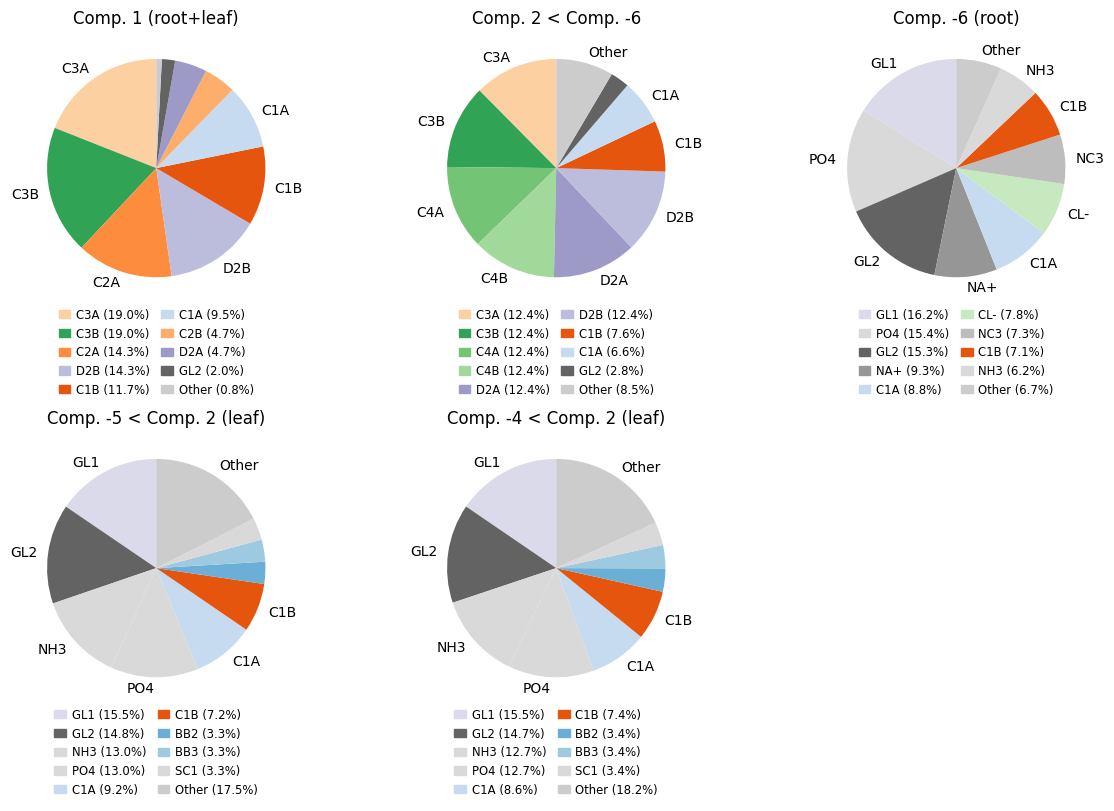

In [51]:
# We can also analyze the compositions of the filtered containment view
composition, fig, axs = cl.analyze_composition(containment_size_filtered, mode='names')

## Performing some hierarchical analysis
The goal is to select a random non_root and non-leaf container if there is one.
This is a rather arbitrary goal, but we hope it illustrates
how one can use a topological description to handle high
throughput data with noise. Quickly filtering interesting cases
which can be processed with more attention.

In [52]:
# Preparing the node sets for our selection
all_nodes = set(containment.voxel_containment.nodes)
root_nodes = set(containment.voxel_containment.root_nodes)
leaf_nodes = set(containment.voxel_containment.leaf_nodes)

# Select non-root and non-leaf nodes
container_nodes = list(all_nodes ^ (root_nodes | leaf_nodes))
# Shuffle the possible nodes for random selection
random.shuffle(container_nodes)
# Pick the first node in the shuffle list of possible container nodes
try:
    node = container_nodes[0]
    print(f'Selected non-root container: {node}')
except IndexError:
    print('No component satisfies the specified conditions.')

Selected non-root container: 2


In [53]:
# Get the atomgroup from the list of nodes.
visualize = False
if node is not None:
    container = containment.get_atomgroup_from_nodes([node], containment=True)
    print(f'Atomgroup with {len(container)} atoms.')
    # Write the atomgroup
    container.write('random_container.pdb')
    # Visualize with VMD
    if visualize:
        !{vmd} random_container.gro
else:
    raise ValueError('There are no non-root containers in the system.')

Atomgroup with 89893 atoms.


### Plotting the composition of the container and its contents
#### Counting the resnames in the atomgroup.atoms

In [54]:
# Make another view to only get the nodes downstream of the selected node
containment_nonroot_container = containment.node_view([node])
nodes = [node]

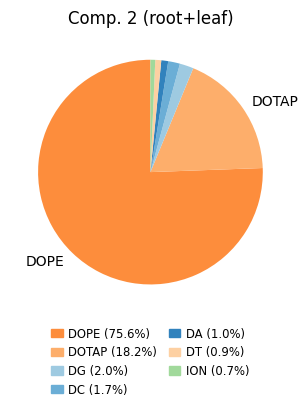

In [55]:
composition, fig, axs = cl.analyze_composition(containment_nonroot_container, mode='resnames')

#### Counting the names in the atomgroup.atoms

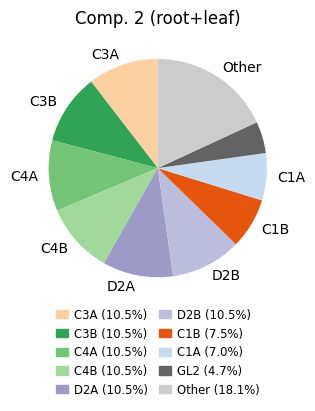

In [56]:
composition, fig, axs = cl.analyze_composition(containment_nonroot_container, mode='names')

## Demonstrating the power of views!
Views are a powerful way in which one can work with containment. You can make a view by using `(Voxel)Containment.node_view([nodes], min_size=0)`. A view will rebuild the non_label_contact_graph, component_contact_graph and containment_graph by merging all nodes not specified upstream. No copies of the memory intensive arrays are made, but they are indexed in a remapped fashion. This makes it easy for a user to work with a reduced version of the contact graph. 

Nearly all methods for the original (Voxel)Containment and their Views are identical, except for some very specific one such as: `VoxelContainmentView.get_original_nodes(self, view_node)` and `VoxelContainmentView.get_view_node(self, original_node)` which indicate which view nodes where mapped to which original nodes.

In [57]:
print(containment.get_atomgroup_from_nodes([node]).__repr__())
print(containment)

print(containment_nonroot_container.get_atomgroup_from_nodes([node]).__repr__())
print(containment_nonroot_container)

original_nodes = [int(sub_node) for sub_node in containment_nonroot_container.voxel_containment.get_original_nodes(node)]
print(f'Original nodes merged into node {node}: {original_nodes}')

<AtomGroup with 67004 atoms>
Containment Graph with 8 components (component: nm^3: rank):
├── [-6: 79573: 2]
│   └── [2: 7262: 0]
│       ├── [-2: 378: 0]
│       ├── [-5: 749: 0]
│       ├── [-4: 1062: 0]
│       ├── [-3: 348: 0]
│       └── [-1: 356: 0]
└── [1: 3884: 2]

<AtomGroup with 89893 atoms>
Containment Graph with 1 components (component: nm^3: rank):
└── [2: 10157: 0]

Original nodes merged into node 2: [2, -2, -5, -4, -3, -1]


In [58]:
# Show the interactive widget plotting
#cl.show_containment_with_composition(containment, max_display_items=1000, mode='resnames')

In [71]:
containment_view = containment.node_view([-2,1,2,-6])
print(containment_view)

Containment Graph with 4 components (component: nm^3: rank):
├── [1: 3884: 2]
└── [-6: 79573: 2]
    └── [2: 9778: 0]
        └── [-2: 378: 0]



In [72]:
containment_view_view = containment.node_view([1, 2, -6])
print(containment_view_view)

Containment Graph with 3 components (component: nm^3: rank):
├── [1: 3884: 2]
└── [-6: 79573: 2]
    └── [2: 10157: 0]



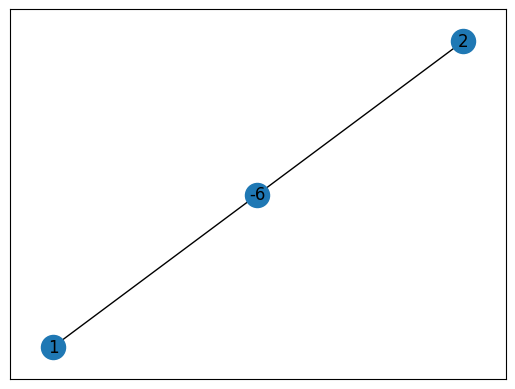

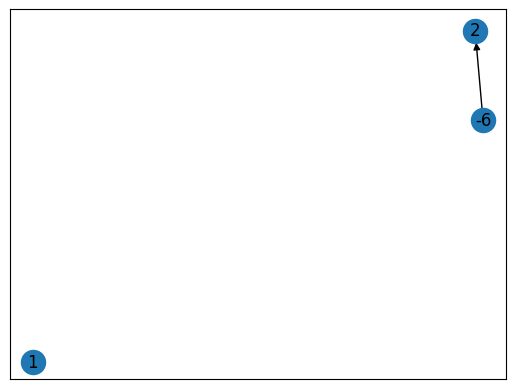

In [73]:
import networkx as nx
nx.draw_networkx(containment_view_view.voxel_containment.component_contact_graph)
plt.show()
nx.draw_networkx(containment_view_view.voxel_containment.containment_graph)
plt.show()